In [5]:
%matplotlib widget

# import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgb, to_rgba
import matplotlib as mpl

import jax.numpy as jnp
import numpy as np
from jax import random


import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)


In [6]:
def f(t, z, args):
    x, v = z

    dxdt = v
    gamma = 0.1
    dvdt = -x - gamma*v

    return jnp.array([dxdt, dvdt])

from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController

ts = jnp.linspace(0, 1000, 1000)

term = ODETerm(f)
solver = Dopri5()
saveat = SaveAt(ts=ts)
stepsize_controller = PIDController(rtol=1e-4, atol=1e-4)
z_init = jnp.array([1., 0.])
sol = diffeqsolve(term, solver, saveat=saveat, t0=0, t1=ts.max(), dt0=.01, y0=z_init, stepsize_controller=stepsize_controller, max_steps=None)

ts_sol = sol.ts
sol = sol.ys

sol_x = sol[:,:1].squeeze()
sol_v = sol[:,1:].squeeze()
Y = sol_x

In [7]:
# spectrogramm
# Parameters for STFT
window_size = len(ts) // 10  # Size of the window
overlap = int(window_size / 2)  # 50% overlap
nfft = 256  # Number of FFT points

from scipy.signal import stft


# Compute the STFT for each 'x'
f, t_, Zxx = stft(sol_x, nperseg=window_size, noverlap=overlap, nfft=nfft)
t_stft = t_ * ts.max() / t_.max()
Zxx = np.abs(Zxx)


91.09109


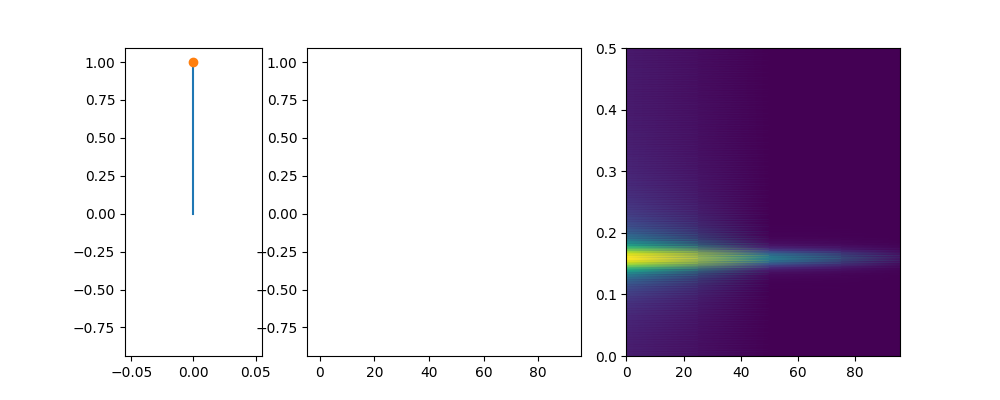

In [8]:
fig, axd = plt.subplot_mosaic("abc", figsize=(10, 4), width_ratios=[1, 2,2])
ax1 = axd['a']
ax2 = axd['b']
ax3 = axd['c']

# init anim
l1, = ax1.plot([0,0], [0, sol_x[0]], '-')
l1_, = ax1.plot([0], [sol_x[0]], ls='none', marker="o")
ax1.dataLim.x0 = 0
ax1.dataLim.x1 = 0
ax1.dataLim.y0 = sol_x.min()
ax1.dataLim.y1 = sol_x.max()

l2, = ax2.plot(ts_sol[:1], sol_x[:1], '-')
ax2.dataLim.x0 = 0
t_max = ts_sol[(np.abs(sol_x) > 1e-2)].max()
print(t_max)
ax2.dataLim.x1 = t_max
ax2.dataLim.y0 = sol_x.min()
ax2.dataLim.y1 = sol_x.max()

# plot the spectrogram
l3 = ax3.pcolormesh(t_, f, Zxx, shading='gouraud')
ax3.dataLim.x0 = 0
ax3.dataLim.x1 = t_max

# plot an animation
def update(ti):
    # plot just the position on ax1
    l1.set_ydata([0, sol_x[ti]])
    l1_.set_ydata([sol_x[ti]])

    # plot the time series on ax2
    l2.set_xdata(ts_sol[:ti])
    l2.set_ydata(sol_x[:ti])

    # plot the spectrogram
    Zxx_ = Zxx.copy()
    ti_stft = np.argmin(np.abs(t_stft - ts_sol[ti]))
    ti_stft = min(ti_stft, Zxx.shape[1])
    Zxx_[:, ti_stft:] = 0.
    l3.set_array(Zxx_.ravel())

    return l1, l2

fps = 60
interval = 1000/fps
ani = FuncAnimation(fig, update, frames=1000, interval=interval, blit=True)
plt.show()

# import os
# from pathlib import Path
# ani.save(Path(globals()["__vsc_ipynb_file__"]).parent / 'stochastic_resonance.gif', writer='imagemagick', fps=60)


In [9]:
ani

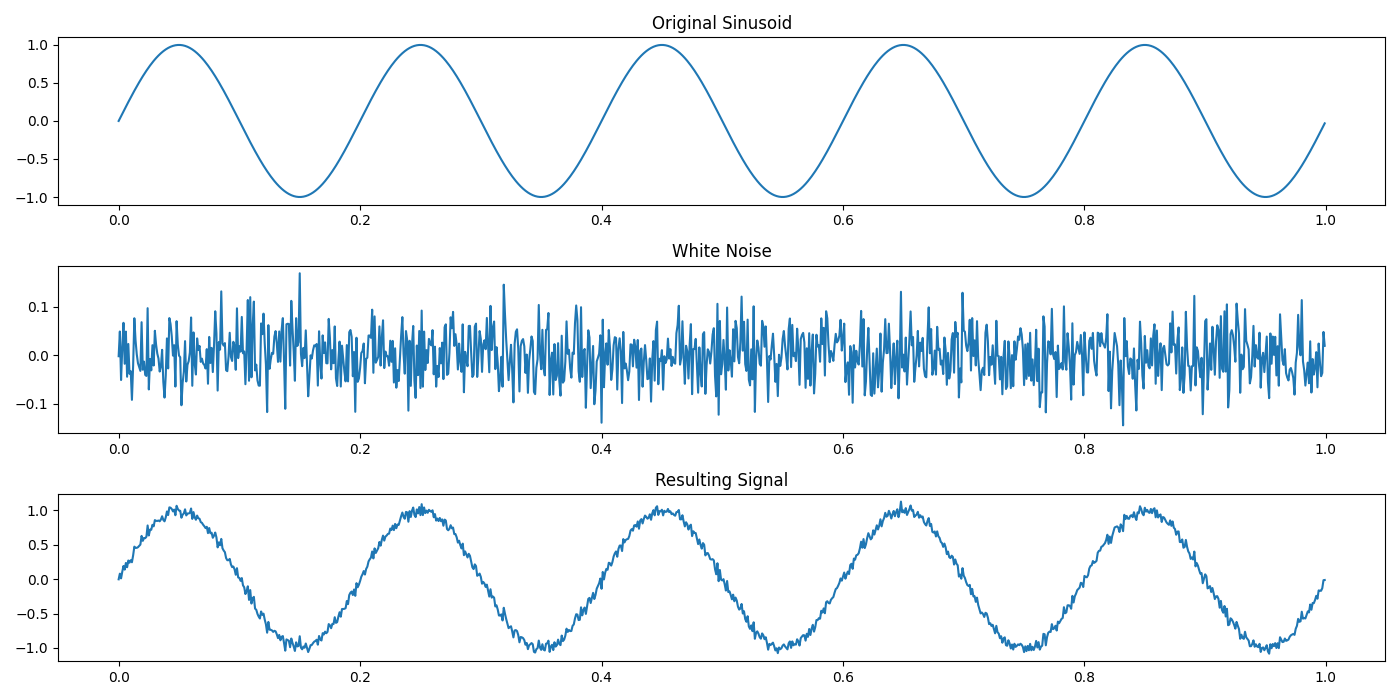

In [6]:
# Create a time vector
t = np.linspace(0, 1, 1000, False)  # 1 second

# Create a sinusoidal signal
freq = 5  # frequency of the signal
sinusoid = np.sin(2*jnp.pi*freq*t)

# Create white noise
noise = np.random.normal(0, 0.05, 1000)

# Add the sinusoid and the noise
signal = sinusoid + noise

# Plot the original sinusoid, the noise, and the resulting signal
plt.figure(figsize=(14, 7))
plt.subplot(3,1,1)
plt.plot(t, sinusoid)
plt.title('Original Sinusoid')
plt.subplot(3,1,2)
plt.plot(t, noise)
plt.title('White Noise')
plt.subplot(3,1,3)
plt.plot(t, signal)
plt.title('Resulting Signal')
plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 129 but corresponding boolean dimension is 2709

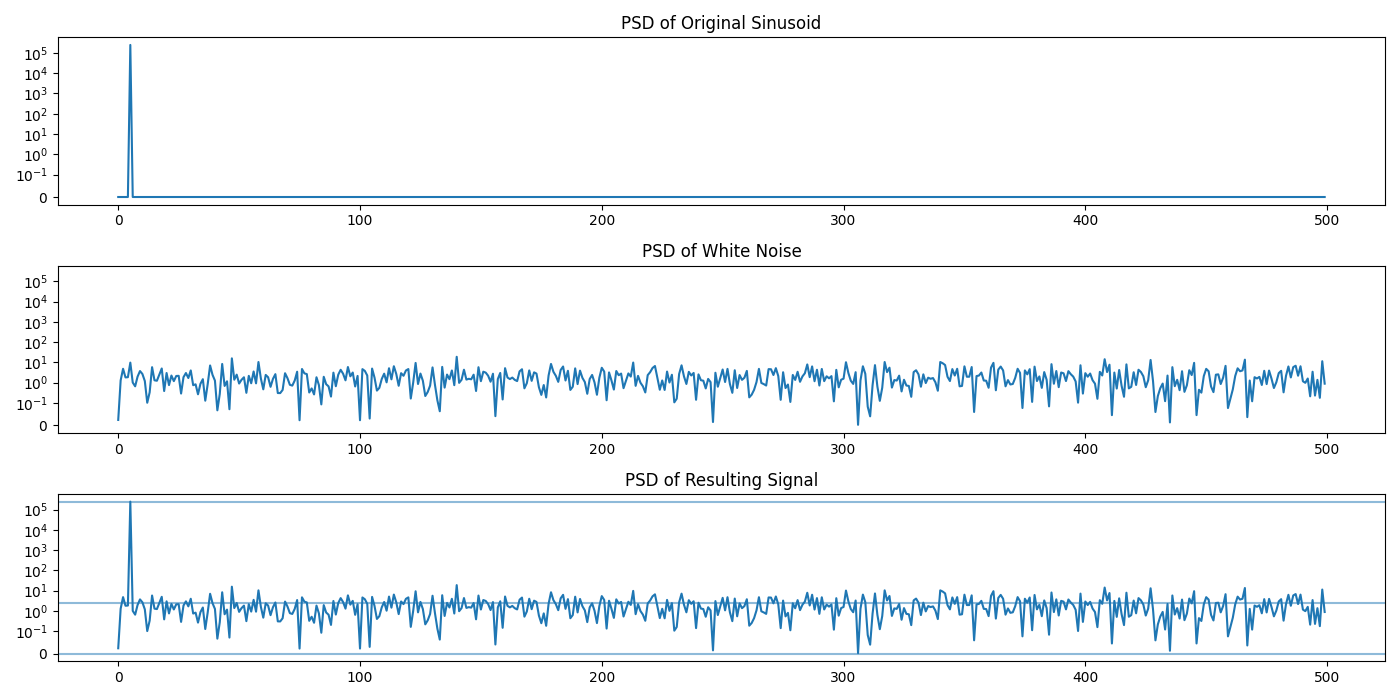

In [7]:
# Compute the FFT
fft_sinusoid = fft(sinusoid)
fft_noise = fft(noise)
fft_signal = fft(signal)

# Compute the power spectral density
psd_sinusoid = np.abs(fft_sinusoid) ** 2
psd_noise = np.abs(fft_noise) ** 2
psd_signal = np.abs(fft_signal) ** 2

# Compute the frequencies corresponding to the values of the PSD
freqs = np.fft.fftfreq(len(sinusoid), t[1]-t[0])

# Plot the power spectral density
fig, axs = plt.subplots(3, 1, figsize=(14, 7), sharey=True)
axs[0].plot(freqs[:len(freqs)//2], psd_sinusoid[:len(psd_sinusoid)//2])
axs[0].set_title('PSD of Original Sinusoid')
axs[1].plot(freqs[:len(freqs)//2], psd_noise[:len(psd_noise)//2])
axs[1].set_title('PSD of White Noise')
axs[2].plot(freqs[:len(freqs)//2], psd_signal[:len(psd_signal)//2])
axs[2].set_title('PSD of Resulting Signal')
axs[2].set_yscale("symlog", linthresh=1e-1)

axs[2].axhline(0, zorder=-1, alpha=.5)
axs[2].axhline(np.mean(psd_noise), zorder=-1, alpha=.5)
axs[2].axhline(np.max(psd_signal), zorder=-1, alpha=.5)
fig.tight_layout()
plt.show()
